<center>
<img src="https://habrastorage.org/webt/ia/m9/zk/iam9zkyzqebnf_okxipihkgjwnw.jpeg">
    
## [mlcourse.ai](mlcourse.ai) – Open Machine Learning Course 

Author: [Yury Kashnitskiy](https://yorko.github.io). 
Translated and edited by [Maxim Keremet](https://www.linkedin.com/in/maximkeremet/), [Artem Trunov](https://www.linkedin.com/in/datamove/), and [Aditya Soni](https://www.linkedin.com/in/aditya-soni-0505a9124/). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center> Solution #2. <br> Visual data analysis in Python: EDA of US flights <br> (using Pandas, Matplotlib & Seaborn & Plotly)

<img src='../../img/flight.png' width=50%>


* **Your task** is to write code and perform computations in the cells below

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objs as go
import plotly.express as px

# enable static images of your plot embedded in the notebook
%matplotlib inline 

sns.set() #apply the default default seaborn theme, scaling, and color palette

# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'

* Download the data [archive](http://www.rdatasciencecases.org/Data/Airline/2008.csv.bz2) (Archived ~ 114 Mb, unzipped - ~ 690 Mb). No need to unzip - pandas can unbzip on the fly.
* Place it in the "../../data" folder, or change the path below according to your location.
* The dataset has information about carriers and flights between US airports during the year 2008. 
* Column description is available [here](http://www.transtats.bts.gov/Fields.asp?Table_ID=236). Visit this site to find ex. meaning of flight cancellation codes.

**Reading data into memory and creating a Pandas _DataFrame_ object**

(This may take a while, be patient)

We are not going to read in the whole dataset. In order to reduce memory footprint, we instead load only needed columns and cast them suitable data types.

In [2]:
dtype = {'DayOfWeek': np.uint8, 'DayofMonth': np.uint8, 'Month': np.uint8 , 'Cancelled': np.uint8, 
         'Year': np.uint16, 'FlightNum': np.uint16 , 'Distance': np.uint16, 
         'UniqueCarrier': str, 'CancellationCode': str, 'Origin': str, 'Dest': str,
         'ArrDelay': np.float16, 'DepDelay': np.float16, 'CarrierDelay': np.float16,
         'WeatherDelay': np.float16, 'NASDelay': np.float16, 'SecurityDelay': np.float16,
         'LateAircraftDelay': np.float16, 'DepTime': np.float16}

In [3]:
%%time
# change the path if needed
path = '../../data/2008.csv.bz2'
flights_df = pd.read_csv(path, usecols=dtype.keys(), dtype=dtype)

CPU times: user 25.5 s, sys: 279 ms, total: 25.8 s
Wall time: 25.8 s


**Check the number of rows and columns and print column names.**

In [4]:
print(flights_df.shape)
print(flights_df.columns)

(7009728, 19)
Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'FlightNum', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Distance',
       'Cancelled', 'CancellationCode', 'CarrierDelay', 'WeatherDelay',
       'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')


**Print first 5 rows of the dataset.**

In [5]:
flights_df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,Distance,Cancelled,CancellationCode,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,WN,335,-14.0,8.0,IAD,TPA,810,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,WN,3231,2.0,19.0,IAD,TPA,810,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,WN,448,14.0,8.0,IND,BWI,515,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,WN,1746,-6.0,-4.0,IND,BWI,515,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,WN,3920,34.0,34.0,IND,BWI,515,0,NaN,2.0,0.0,0.0,0.0,32.0


**Transpose the frame to see all features at once.**

In [6]:
flights_df.head().T

,0,1,2,3,4
Year,2008,2008,2008,2008,2008
Month,1,1,1,1,1
DayofMonth,3,3,3,3,3
DayOfWeek,4,4,4,4,4
DepTime,2003,754,628,926,1829
UniqueCarrier,WN,WN,WN,WN,WN
FlightNum,335,3231,448,1746,3920
ArrDelay,-14,2,14,-6,34
DepDelay,8,19,8,-4,34
Origin,IAD,IAD,IND,IND,IND


**Examine data types of all features and total dataframe size in memory.**

In [7]:
flights_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 19 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               uint16 
 1   Month              uint8  
 2   DayofMonth         uint8  
 3   DayOfWeek          uint8  
 4   DepTime            float16
 5   UniqueCarrier      object 
 6   FlightNum          uint16 
 7   ArrDelay           float16
 8   DepDelay           float16
 9   Origin             object 
 10  Dest               object 
 11  Distance           uint16 
 12  Cancelled          uint8  
 13  CancellationCode   object 
 14  CarrierDelay       float16
 15  WeatherDelay       float16
 16  NASDelay           float16
 17  SecurityDelay      float16
 18  LateAircraftDelay  float16
dtypes: float16(8), object(4), uint16(3), uint8(4)
memory usage: 387.7+ MB


**Get basic statistics of each feature.**

In [8]:
flights_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,7009728.0,2008.000000,0.000000,2008.0,2008.0,2008.0,2008.0,2008.0
Month,7009728.0,6.375130,3.406737,1.0,3.0,6.0,9.0,12.0
DayofMonth,7009728.0,15.728015,8.797068,1.0,8.0,16.0,23.0,31.0
DayOfWeek,7009728.0,3.924182,1.988259,1.0,2.0,4.0,6.0,7.0
DepTime,6873482.0,NaN,NaN,1.0,928.0,1325.0,1728.0,2400.0
FlightNum,7009728.0,2224.200105,1961.715999,1.0,622.0,1571.0,3518.0,9743.0
ArrDelay,6855029.0,NaN,NaN,-519.0,-10.0,-2.0,12.0,2460.0
DepDelay,6873482.0,NaN,NaN,-534.0,-4.0,-1.0,8.0,2468.0
Distance,7009728.0,726.387029,562.101803,11.0,325.0,581.0,954.0,4962.0
Cancelled,7009728.0,0.019606,0.138643,0.0,0.0,0.0,0.0,1.0


**Count unique Carriers and plot their relative share of flights:**

In [9]:
flights_df['UniqueCarrier'].nunique()

20

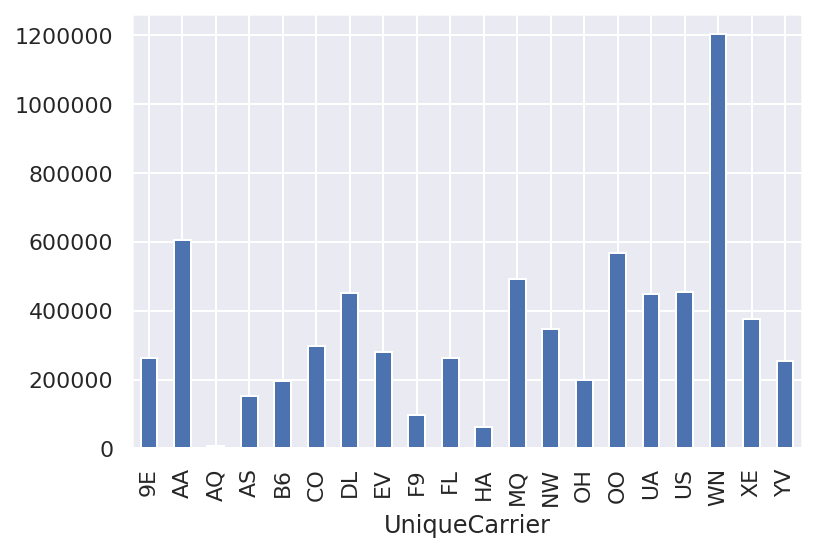

In [10]:
flights_df.groupby('UniqueCarrier').size().plot(kind='bar');

**We can also _group by_ category/categories in order to calculate different aggregated statistics.**

**For example, finding top-3 flight codes, that have the largest total distance travelled in year 2008.**

In [11]:
flights_df.groupby(['UniqueCarrier','FlightNum'])['Distance'].sum().sort_values(ascending=False).iloc[:3]

UniqueCarrier  FlightNum
CO             15           1796244.0
               14           1796244.0
UA             52           1789722.0
Name: Distance, dtype: float64

**Another way:**

In [12]:
flights_df.groupby(['UniqueCarrier','FlightNum'])\
  .agg({'Distance': [np.mean, np.sum, 'count'],
        'Cancelled': np.sum})\
  .sort_values(('Distance', 'sum'), ascending=False)\
  .iloc[0:3]

Distance                  Cancelled
                                mean        sum count       sum
UniqueCarrier FlightNum                                        
CO            15         4962.000000  1796244.0   362         0
              14         4962.000000  1796244.0   362         0
UA            52         2465.181818  1789722.0   726         8

**Number of flights by days of week and months:**

In [13]:
pd.crosstab(flights_df.Month, flights_df.DayOfWeek)

DayOfWeek,1,2,3,4,5,6,7
Month,,,,,,,
1,80807,97298,100080,102043,81940,67178,76419
2,81504,79700,80587,82158,102726,66462,76099
3,103210,81159,82307,82831,82936,86153,97494
4,82463,100785,102586,82799,82964,68304,78225
5,80626,79884,81264,102572,102878,84493,74576
6,104168,82160,82902,83617,83930,72322,99566
7,84095,103429,103315,105035,79349,72219,80489
8,82983,80895,81773,82625,103878,86155,93970
9,94300,91533,74057,75589,75881,58343,71205


**It can also be handy to color such tables in order to easily notice outliers:**

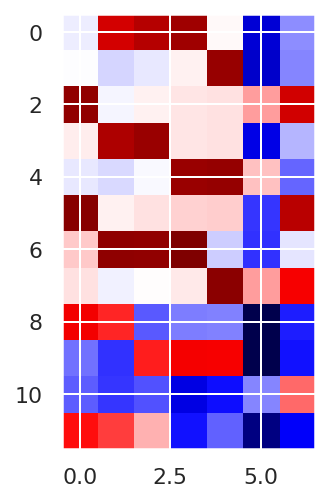

In [14]:
plt.imshow(pd.crosstab(flights_df.Month, flights_df.DayOfWeek),
           cmap='seismic', interpolation='none');

**Flight distance histogram:**

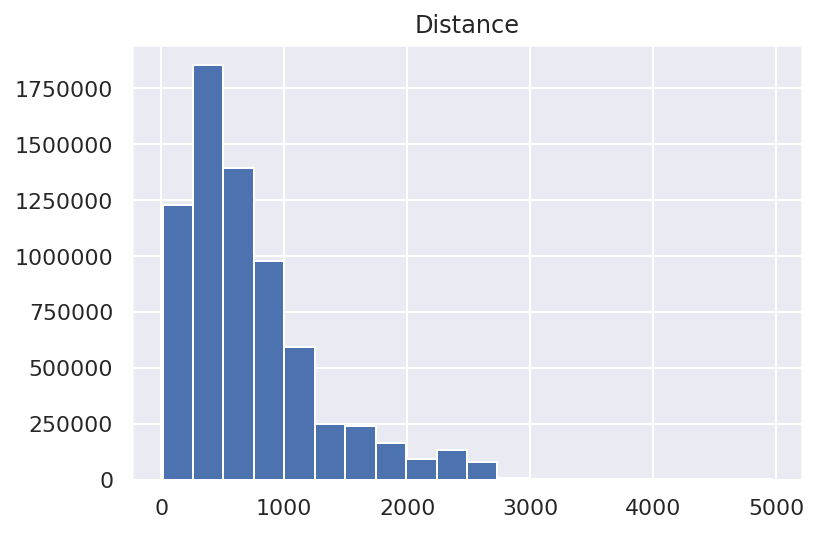

In [15]:
flights_df.hist('Distance', bins=20);

**Making a histogram of flight frequency by date.**

In [16]:
flights_df['Date'] = pd.to_datetime(flights_df.rename(columns={'DayofMonth': 'Day'})[['Year', 'Month', 'Day']])

In [17]:
num_flights_by_date = flights_df.groupby('Date').size()

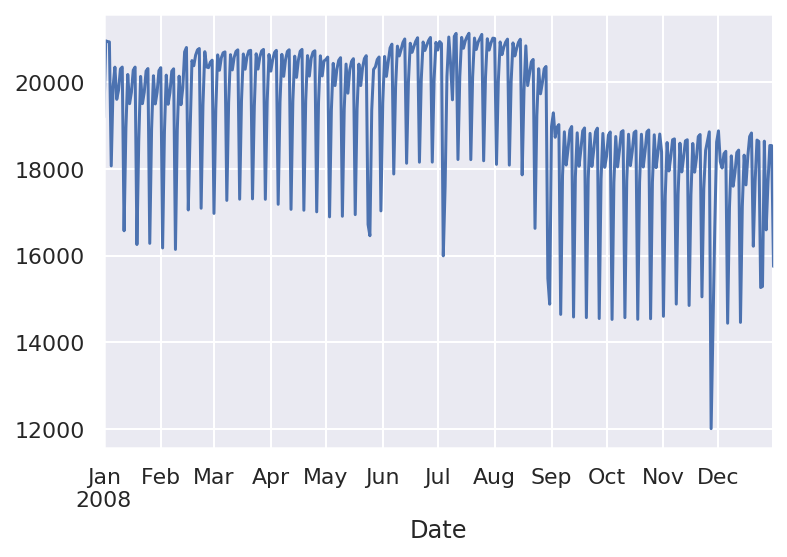

In [18]:
num_flights_by_date.plot();

**Do you see a weekly pattern above? And below?**

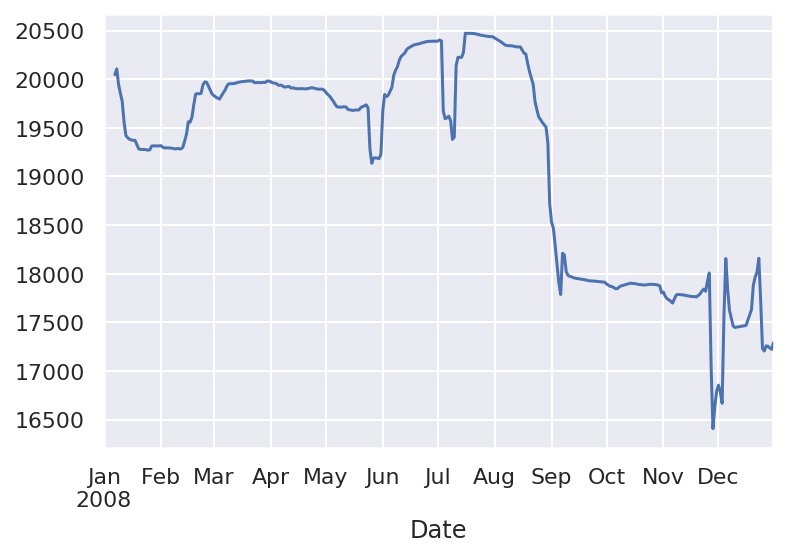

In [19]:
num_flights_by_date.rolling(window=7).mean().plot();

**We'll need a new column in our dataset - departure hour, let's create it.**

As we see, `DepTime` is distributed from 1 to 2400 (it is given in the `hhmm` format, check the [column description](https://www.transtats.bts.gov/Fields.asp?Table_ID=236) again). We'll treat departure hour as `DepTime` // 100 (divide by 100 and apply the `floor` function). However, now we'll have both hour 0 and hour 24. Hour 24 sounds strange, we'll set it to be 0 instead (a typical imperfectness of real data, however, you can check that it affects only 521 rows, which is sort of not a big deal). So now values of a new column `DepHour` will be distributed from 0 to 23. There are some missing values, for now we won't fill in them, just ignore them. 

In [20]:
flights_df['DepHour'] = flights_df['DepTime'] // 100
flights_df['DepHour'].replace(to_replace=24, value=0, inplace=True)

In [21]:
flights_df['DepHour'].describe()

count    6873482.0
mean           NaN
std            0.0
min            0.0
25%            9.0
50%           13.0
75%           17.0
max           23.0
Name: DepHour, dtype: float64

**1. Find top-10 carriers in terms of the number of completed flights (_UniqueCarrier_ column)?**

**Which of the listed below is _not_ in your top-10 list?**
- DL
- AA
- OO
- EV <span style="color:green"> **[+]** </span>

In [22]:
# solution
top10_airlines = flights_df.loc[flights_df['Cancelled'] == 0,
                                'UniqueCarrier'].value_counts().head(10)
top10_airlines

WN    1189365
AA     587445
OO     554723
MQ     472362
US     447007
DL     445118
UA     438974
XE     364518
NW     344746
CO     294753
Name: UniqueCarrier, dtype: int64

**2. Plot distributions of flight cancellation reasons (_CancellationCode_).**

**What is the most frequent reason for flight cancellation? (Use this [link](https://www.transtats.bts.gov/Fields.asp?Table_ID=236) to translate codes into reasons)**
- carrier
- weather conditions <span style="color:green"> **[+]** </span>
- National Air System
- security reasons

****
*Reminder on Cancellatoin codes:*
```
A - Carrier 
B - Weather 
C - National Air System 
D - Security
```
****

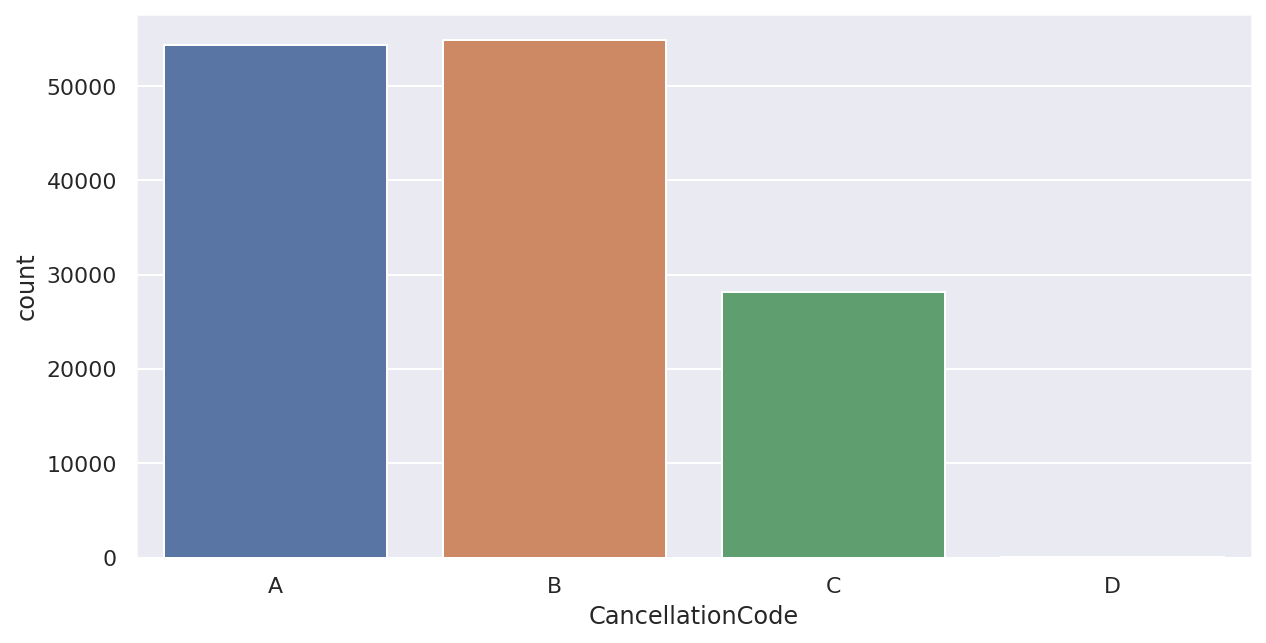

In [23]:
# solution
plt.figure(figsize=(10, 5))
sns.countplot(flights_df['CancellationCode'].sort_values());

In [24]:
flights_df['CancellationCode'].mode()

0    B
dtype: object

**3. Which route is the most frequent, in terms of the number of flights?**

(Take a look at _'Origin'_ and _'Dest'_ features. Consider _A->B_ and _B->A_ directions as _different_ routes) 

 - New-York – Washington
 - San-Francisco – Los-Angeles <span style="color:green"> **[+]** </span>
 - San-Jose – Dallas
 - New-York – San-Francisco

In [25]:
# solution
flights_df['Route'] = flights_df['Origin'] + '->' + flights_df['Dest']
flights_df['Route'].value_counts().head()

SFO->LAX    13788
LAX->SFO    13390
OGG->HNL    12383
LGA->BOS    12035
BOS->LGA    12029
Name: Route, dtype: int64

**4. Find top-5 delayed routes (count how many times they were delayed on departure). From all flights on these 5 routes, count all flights with weather conditions contributing to a delay.**

**Hint:** consider only positive delays


- 449 
- 539 
- 549 
- 668 <span style="color:green"> **[+]** </span>

In [26]:
# solution
# find top5 routes with most delayed flights
top5_delayed = flights_df[flights_df['DepDelay'] > 0].groupby('Route')\
    .size().sort_values(ascending=False).head(5)

top5_delayed

Route
LAX->SFO    6253
DAL->HOU    5742
SFO->LAX    5322
ORD->LGA    5311
HOU->DAL    5288
dtype: int64

In [27]:
# reduce to only flights from top5 delayed routes
flights_top5_delays = flights_df[flights_df['Route'].isin(top5_delayed.index)]

In [28]:
# now the answer
(flights_top5_delays['WeatherDelay'] > 0).sum()

668

**5. Examine the hourly distribution of departure times. For that, create a new series from DepTime, removing missing values.**

**Choose all correct statements:**
 - Flights are normally distributed within time interval [0-23] (Search for: Normal distribution, bell curve).
 - Flights are uniformly distributed within time interval [0-23].   
 - In the period from 0 am to 4 am there are considerably less flights than from 7 pm to 8 pm. <span style="color:green"> **[+]** </span>

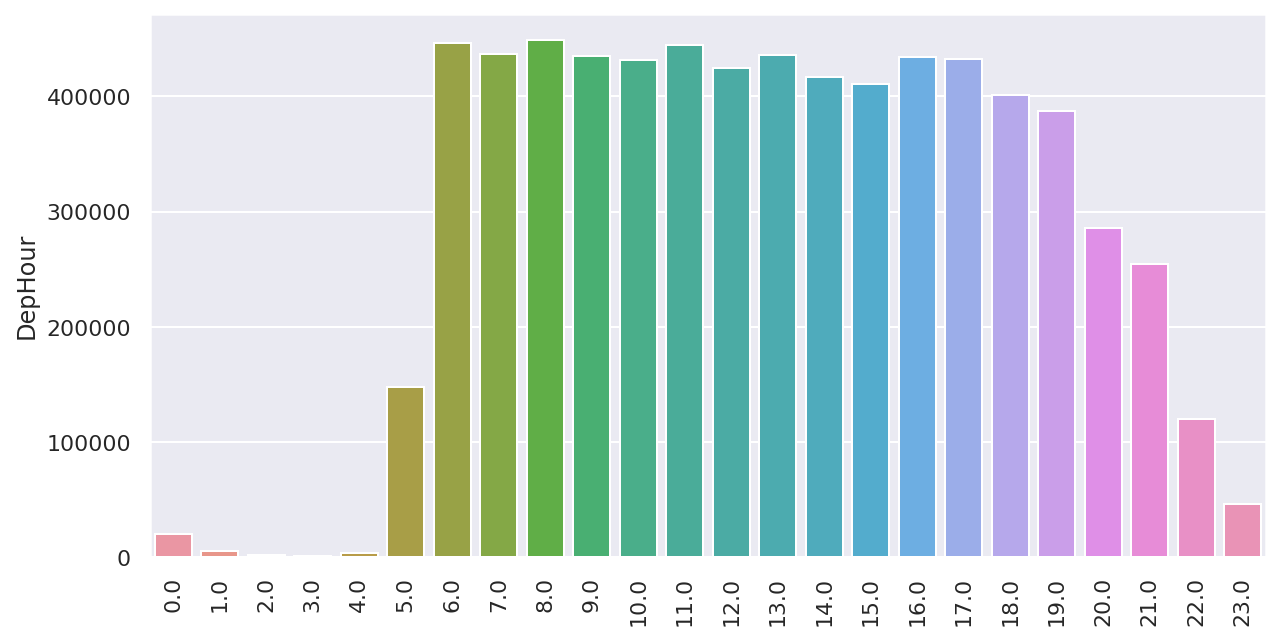

In [29]:
# solution
hour_group = flights_df['DepHour'].value_counts(sort=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=hour_group.index, y=hour_group)
plt.xticks(rotation=90)
plt.show()

In [30]:
# Checking the 3rd statements separately
round((flights_df['DepHour'] == 19).sum() / (flights_df['DepHour'] < 5).sum())

12.0

**6. Show how the number of flights changes through time (on the daily/weekly/monthly basis) and interpret the findings.**

**Choose all correct statements:**
- The number of flights during weekends is less than during weekdays (working days). <span style="color:green"> **[+]** </span>
- The lowest number of flights is on Sunday.
- There are less flights during winter than during summer. <span style="color:green"> **[+]** </span>

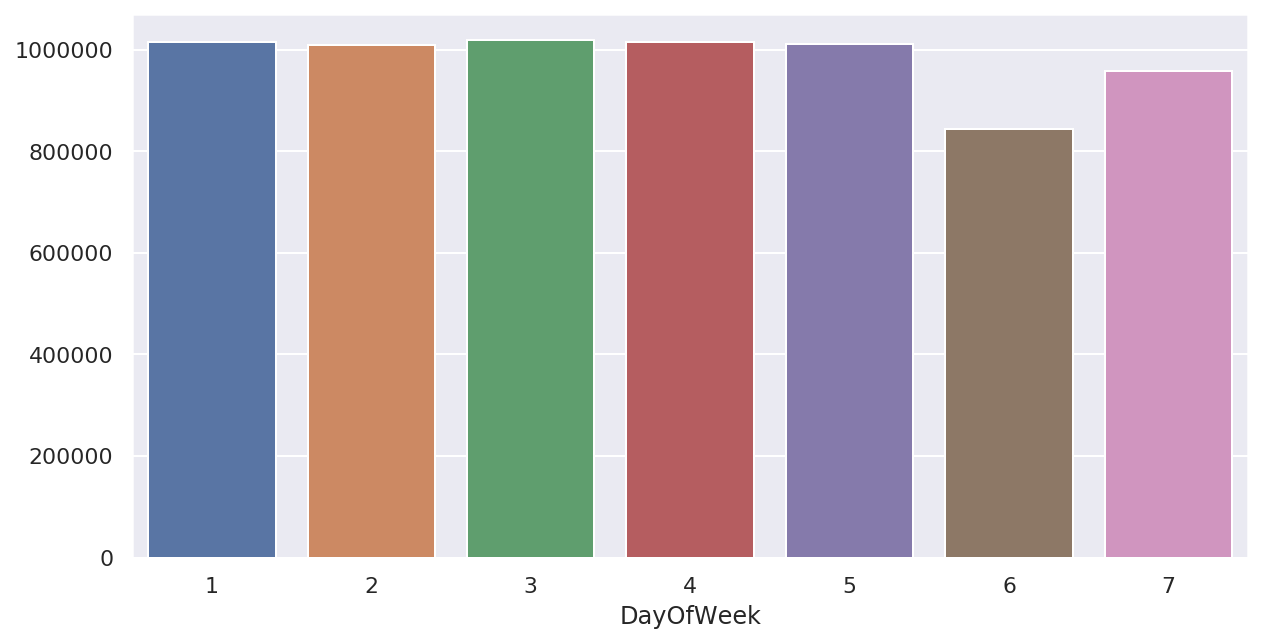

In [31]:
# solution
num_flights_by_day_of_week = flights_df[flights_df['Cancelled'] == 0].groupby(
    'DayOfWeek').size()


plt.figure(figsize=(10, 5))
sns.barplot(x=num_flights_by_day_of_week.index, y=num_flights_by_day_of_week)

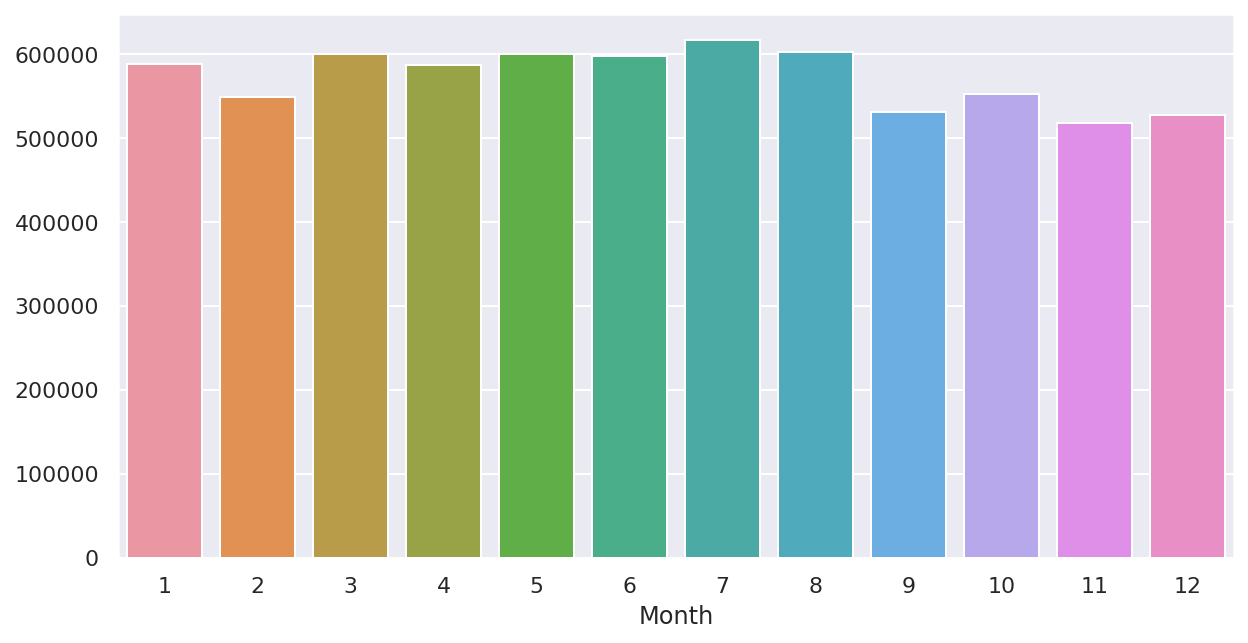

In [32]:
num_flights_by_month = flights_df[flights_df['Cancelled'] == 0].groupby('Month').size()

plt.figure(figsize=(10, 5))
sns.barplot(x=num_flights_by_month.index, y=num_flights_by_month);

**7. Examine the distribution of cancellation reasons with time. Make a bar plot of cancellation reasons aggregated by months.**

**Choose all correct statements:**
- December has the highest rate of cancellations due to weather. <span style="color:green"> **[+]** </span>
- The highest rate of cancellations in September is due to Security reasons.
- April's top cancellation reason is carriers. <span style="color:green"> **[+]** </span>
- Flights cancellations due to National Air System are more frequent than those due to carriers.

****
*Reminder on Cancellatoin codes:*
```
A - Carrier 
B - Weather 
C - National Air System 
D - Security
```
****

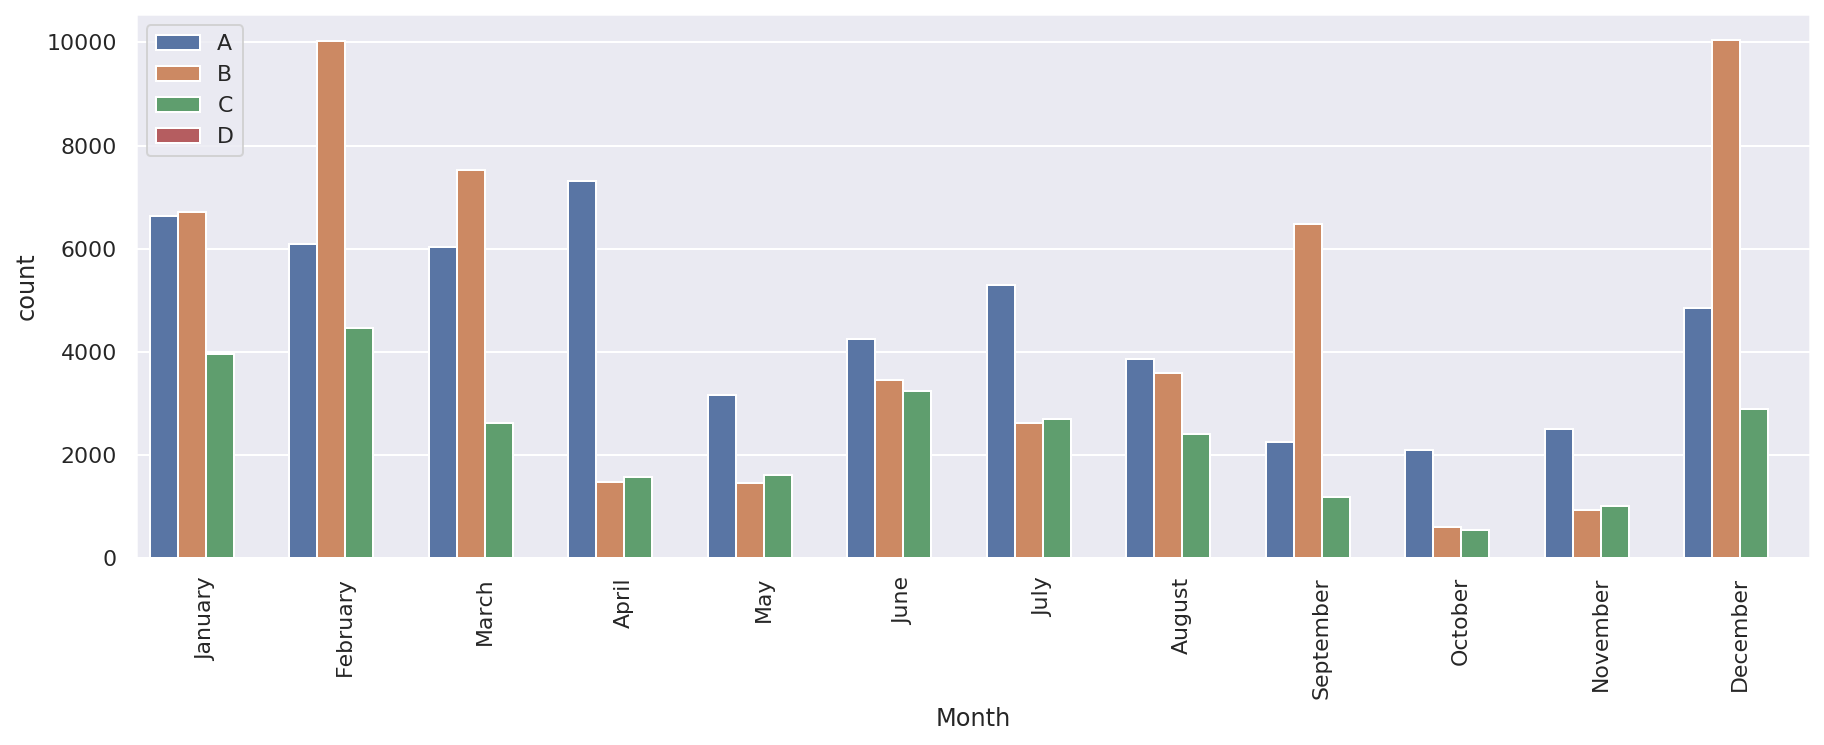

In [33]:
# create a month name list
import calendar

month_names = []
for month_idx in flights_df['Month'].unique():
    month_names.append((calendar.month_name[month_idx]))

cancel_df = (flights_df.groupby(['Month', 'CancellationCode'])
             .size()
             .reset_index()
             .rename(columns={0: 'count'}))

# create a barplot
plt.figure(figsize=(15, 5))

plot = sns.barplot(
    x=cancel_df['Month'], y=cancel_df['count'], hue=cancel_df['CancellationCode'])
plot.set_xticklabels(month_names, rotation=90)
plot.legend(loc='upper left');

**8. Which month has the greatest number of cancellations due to Carrier?** 
- May
- January
- September
- April <span style="color:green"> **[+]** </span>

In [34]:
# solution
flights_df.loc[flights_df['CancellationCode'] == 'A', 'Month'].value_counts().head()

4    7312
1    6635
2    6090
3    6038
7    5292
Name: Month, dtype: int64

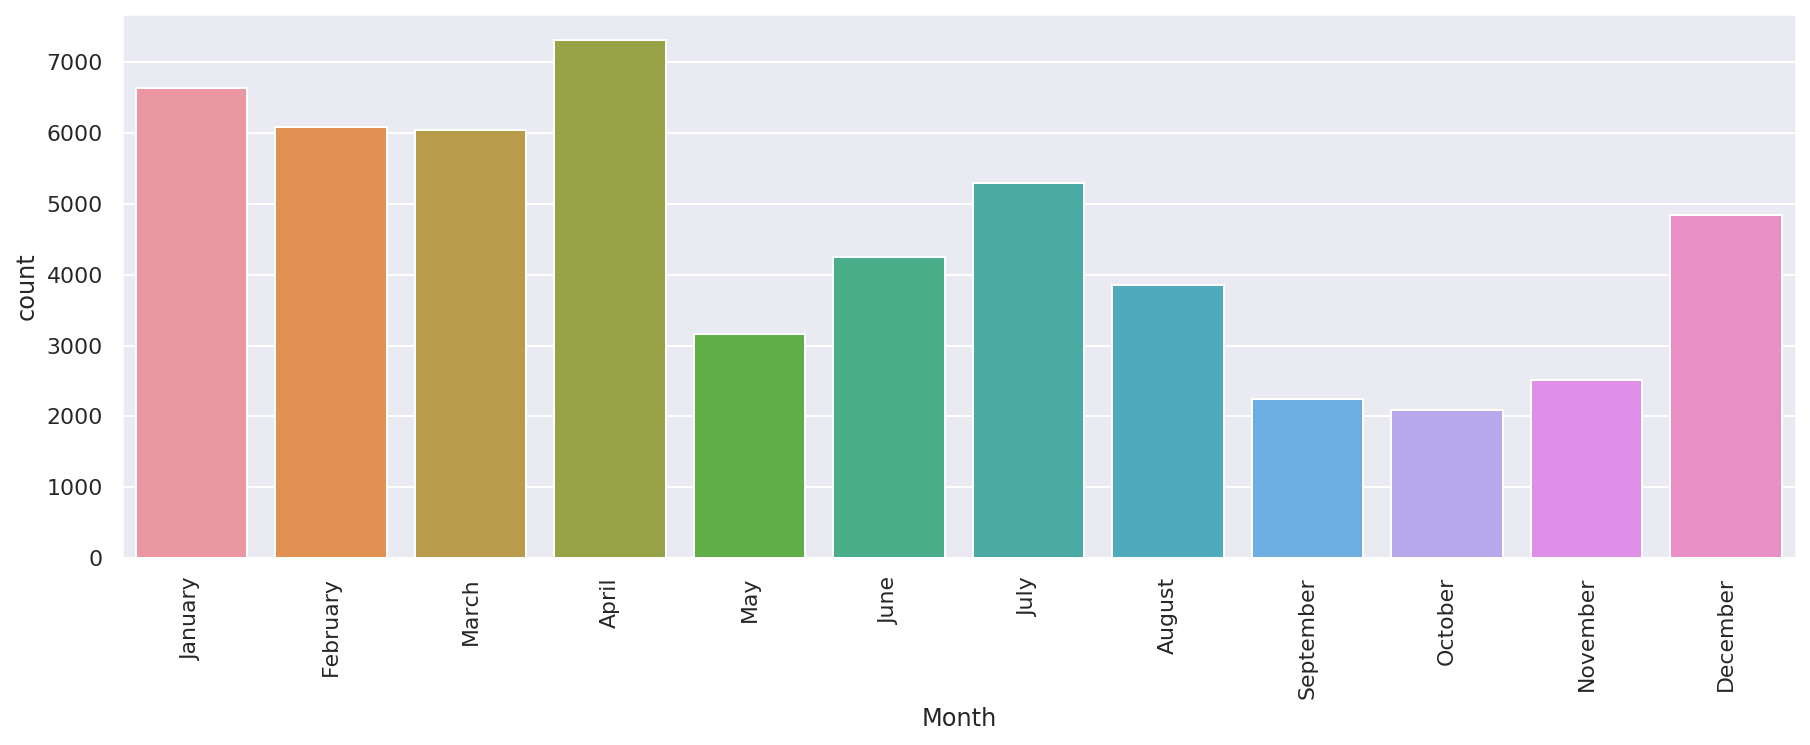

In [35]:
cancel_df = (flights_df[flights_df['CancellationCode'] == 'A']
             .groupby(['Month'])['UniqueCarrier'].count()
             .reset_index()
             .rename(columns={'UniqueCarrier': 'count'}))

plt.figure(figsize=(15, 5))
plot = sns.barplot(
    x=cancel_df['Month'], y=cancel_df['count'])
plot.set_xticklabels(month_names, rotation=90);

**9. Identify the carrier with the greatest number of cancellations due to carrier in the corresponding month from the previous question.**

- 9E
- EV
- HA
- AA <span style="color:green"> **[+]** </span>

In [36]:
# solution
flights_df.loc[(flights_df['CancellationCode'] == 'A') & (flights_df['Month'] == 4),
               'UniqueCarrier'].value_counts().head()

AA    3696
WN     533
UA     494
YV     454
9E     391
Name: UniqueCarrier, dtype: int64

Or, as a nice plot (with much more efforts of course):


 Most cancellated carrier: AA 
 Number of cancellations: 1062.0 
 Date: 2008-04-09 00:00:00


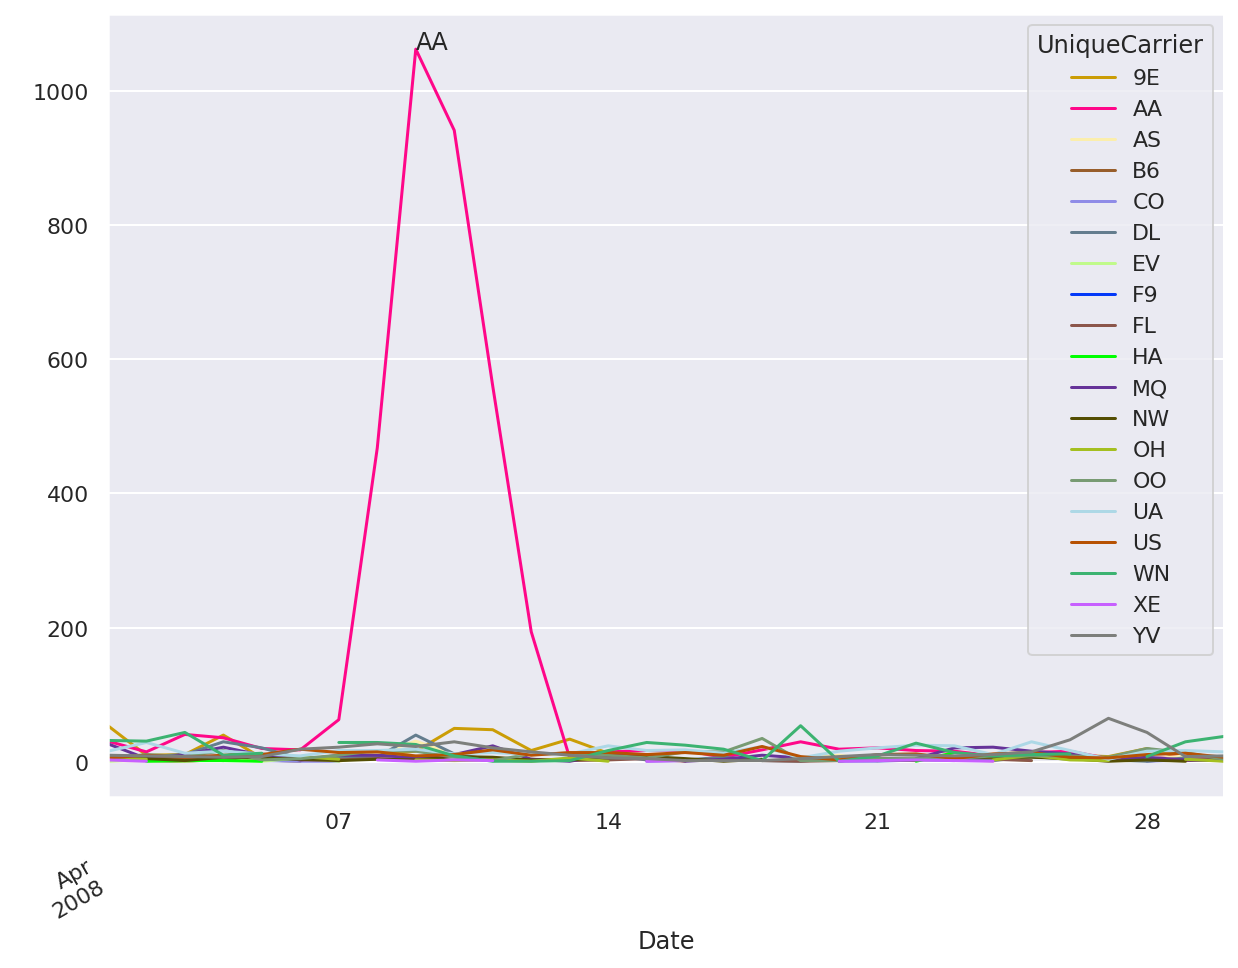

In [37]:
import matplotlib.colors as colors
import random 

colors_list = list(colors._colors_full_map.values())
selected_colors = random.sample(colors_list,20)

cancelled_Carrier_April = (flights_df[(flights_df['CancellationCode'] == 'A') 
                                     & (flights_df['Month'] == 4)]
                .groupby(['Date', 'UniqueCarrier']).size().unstack())

# get the peak coordinates for annotation
max_value = cancelled_Carrier_April.max().max()
carrier_of_max_value = cancelled_Carrier_April.max().idxmax()
date_of_max_value = cancelled_Carrier_April[carrier_of_max_value].idxmax()
print("\n", "Most cancellated carrier:", carrier_of_max_value,
      "\n", "Number of cancellations:", max_value, 
      "\n", "Date:", date_of_max_value)

fig, ax = plt.subplots()

cancelled_Carrier_April.plot(color=selected_colors, figsize=(10,8), ax=ax)
ax.annotate(carrier_of_max_value, (str(date_of_max_value), max_value))
fig.autofmt_xdate()

**or**

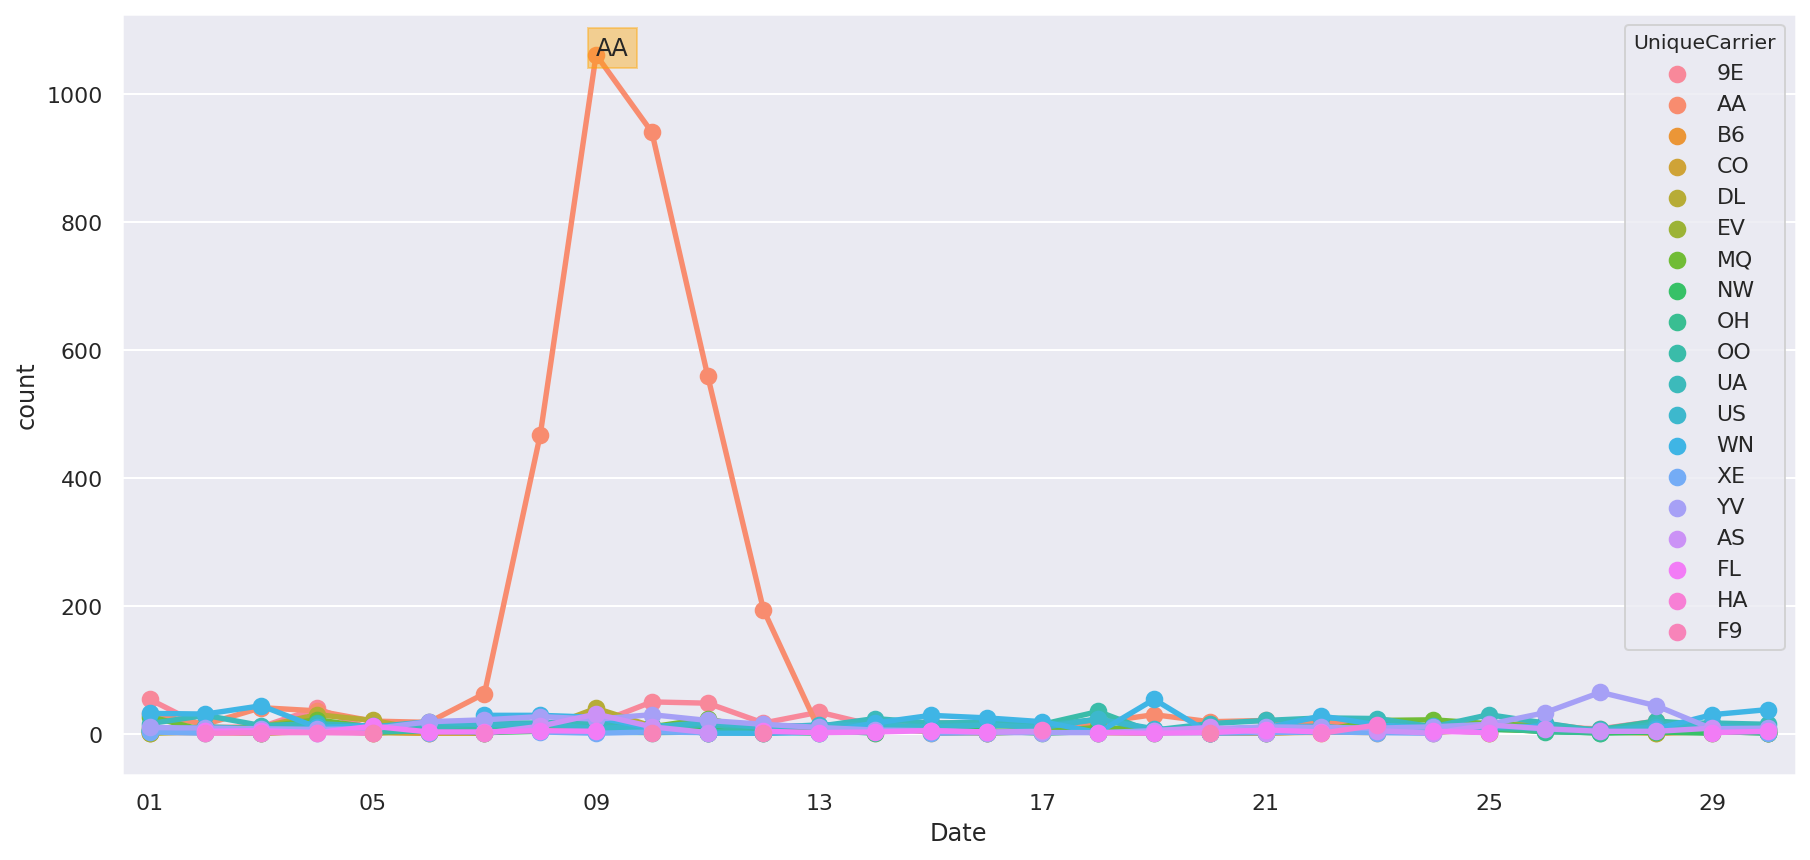

In [38]:
cancelled_Carrier_April = (flights_df[(flights_df['CancellationCode'] == 'A') 
                                     & (flights_df['Month'] == 4)]
                .groupby(['Date', 'UniqueCarrier']).size().reset_index()
                .rename(columns={0: 'count'}))

# get dates range
unique_dates = sorted(list(cancelled_Carrier_April['Date'].drop_duplicates()))
date_ticks = range(0, len(unique_dates), 4)

plt.figure(figsize=(15, 7))
g = sns.pointplot(x="Date", y="count", hue="UniqueCarrier", data=cancelled_Carrier_April)
g.set_xticks(date_ticks)
g.set_xticklabels([unique_dates[i].strftime('%d') for i in date_ticks])

plt.annotate(str(carrier_of_max_value), xy=(8, max_value), xytext=(8, max_value),
             bbox={'pad':4, 'edgecolor':'orange', 'facecolor': 
                   'orange', 'alpha':0.4});

**10. Examine median arrival and departure delays (in time) by carrier. Which carrier has the lowest median delay time for both arrivals and departures? Leave only non-negative values of delay times ('ArrDelay', 'DepDelay').
[Boxplots](https://seaborn.pydata.org/generated/seaborn.boxplot.html) can be helpful in this exercise, as well as it might be a good idea to remove outliers in order to build nice graphs. You can exclude delay time values higher than a corresponding .95 percentile.**

- EV
- OO
- AA
- AQ <span style="color:green"> **[+]** </span>

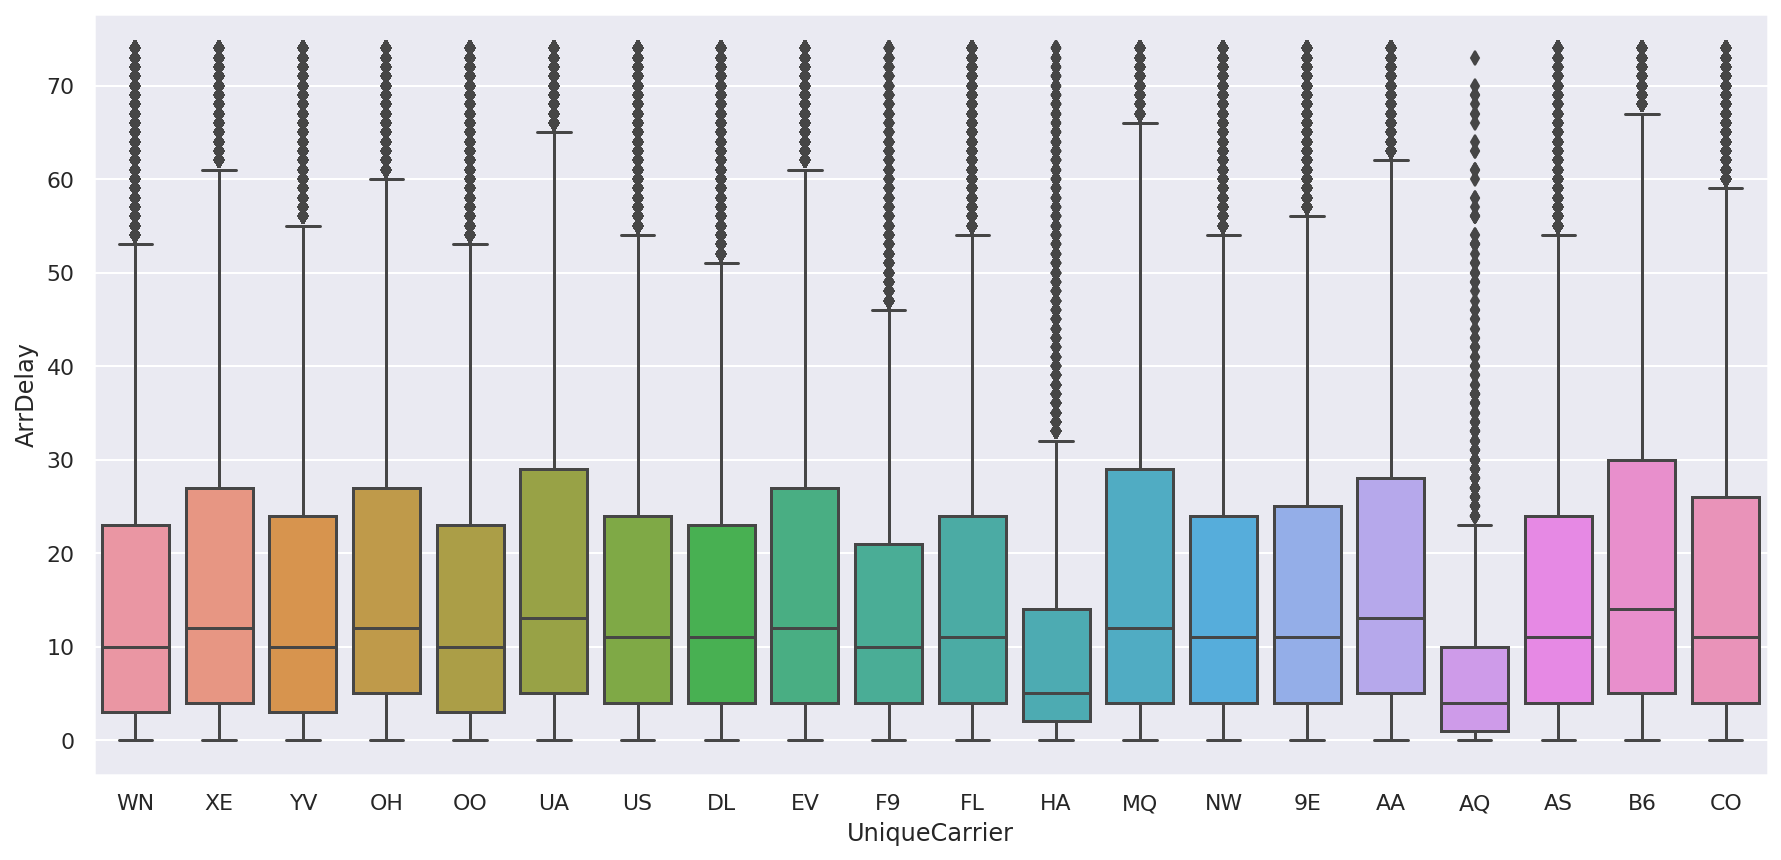

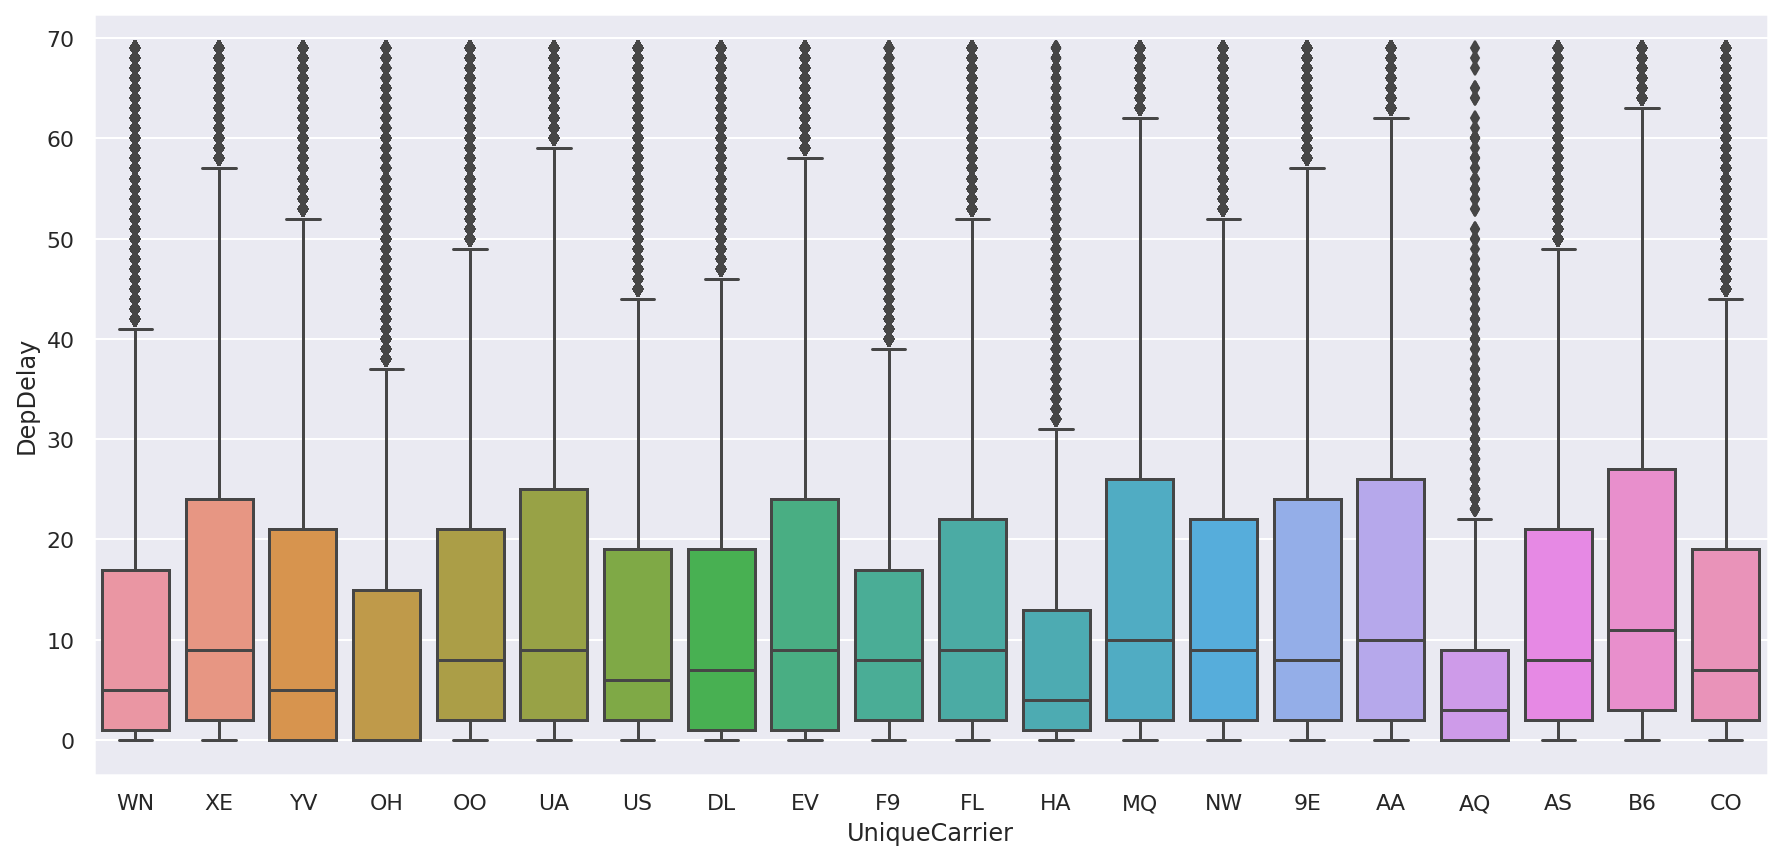

In [39]:
# solution
for delay_type in ['ArrDelay', 'DepDelay']:
    sub_df = flights_df[(flights_df[delay_type] >= 0) &
                        (flights_df[delay_type] < 
                         flights_df[delay_type].quantile(.95))]
    plt.figure(figsize=(15, 7))
    sns.boxplot(x='UniqueCarrier', y=delay_type, data=sub_df)
    plt.show()